# Modeling

The end of the line, this section is comprised of the pre-processing stage, which entails additional feature selection and then encoding for modeling. The next stage is modeling, in which I will select a model that I think is the best for the the data.

Let's get started!

## Pre-processing

In [316]:
# start with imports
import wrangle as w
import explore as e

# library imports
import pandas as pd
import numpy as np

ranstate = 42

In [25]:
# import the data
train,validate,test = w.wrangle_iot2022()

Reading from file...


In [27]:
train.shape

(86181, 84)

### Encoding

The first thing I need to encode the data. Since I will be primarily using SciKitLearn, the algorithms all require the data to be numerically encoded. For this, i will likely also be relying on some pre-built functions.

In [144]:
def encode_df(dframe,target):
	'''
	Takes a processed dataframe and encodes the object columns for usage in modeling.
		Takes a dataframe and a target variable (assuming the target variable is an object). Target variable keeps the thing the model is being trained on from splitting and altering it.
		!!! MAKE ME MORE DYNAMIC !!!
	- Add functionality to check if passed a list or dataframe
	- If dataframe, then run standard loop
	- If list then check if each item is a dataframe (checking for train/validate/test)
	- If list and each item is dataframe, then try loop on each dataframe
	- Otherwise return an error
	'''
	df = dframe.copy()
	# Get the object columns from the dataframe
	obj_col = [col for col in df.columns if df[col].dtype == 'O']
		# remove target variable
	obj_col.remove(target)
		# Begin encoding the object columns
	for col in obj_col:
		# Grab current column dummies
		dummies = pd.get_dummies(df[col],drop_first=True)
				# concatenate the names in a descriptive manner
		dummies.columns = [col+'_is_'+column for column in dummies.columns]
		# add these new columns to the dataframe
		for column in dummies.columns:
			df[column] = dummies[column].astype(float)
				# Drop the old columns from the dataframe
		df = df.drop(columns=col)
	return df 

In [60]:
# Encode all of the dataframes simultaneously
encoded = [encode_df(df,"Attack_type") for df in [train,validate,test]]

In [68]:
[print(df.shape) for df in encoded]

(86181, 93)
(25855, 92)
(11081, 92)


[None, None, None]

Well that's unusual. Why are validate and test missing a column?

In [71]:
[print(df.shape) for df in [train,validate,test]]

(86181, 84)
(25855, 84)
(11081, 84)


[None, None, None]

I can see that I'm losing a column during the encoding process.

In [66]:
encoded[1].columns

Index(['id.orig_p', 'id.resp_p', 'flow_duration', 'fwd_pkts_tot',
       'bwd_pkts_tot', 'fwd_data_pkts_tot', 'bwd_data_pkts_tot',
       'fwd_pkts_per_sec', 'bwd_pkts_per_sec', 'flow_pkts_per_sec',
       'down_up_ratio', 'fwd_header_size_tot', 'fwd_header_size_min',
       'fwd_header_size_max', 'bwd_header_size_tot', 'bwd_header_size_min',
       'bwd_header_size_max', 'flow_FIN_flag_count', 'flow_SYN_flag_count',
       'flow_RST_flag_count', 'fwd_PSH_flag_count', 'bwd_PSH_flag_count',
       'flow_ACK_flag_count', 'fwd_URG_flag_count', 'flow_CWR_flag_count',
       'flow_ECE_flag_count', 'fwd_pkts_payload.min', 'fwd_pkts_payload.max',
       'fwd_pkts_payload.tot', 'fwd_pkts_payload.avg', 'fwd_pkts_payload.std',
       'bwd_pkts_payload.min', 'bwd_pkts_payload.max', 'bwd_pkts_payload.tot',
       'bwd_pkts_payload.avg', 'bwd_pkts_payload.std', 'flow_pkts_payload.min',
       'flow_pkts_payload.max', 'flow_pkts_payload.tot',
       'flow_pkts_payload.avg', 'flow_pkts_payload.std', 

In [83]:
set(encoded[0].columns).symmetric_difference(set(encoded[1].columns))

{'service_is_radius'}

In [85]:
set(encoded[0].columns).symmetric_difference(set(encoded[2].columns))

{'service_is_radius'}

So in both, the 'service_is_radius' column is missing.

What I'm going to do is adjust the function so that no columns are dropped and see what I get from that.

In [146]:
def encode_df(dframe,target):
	'''
	Takes a processed dataframe and encodes the object columns for usage in modeling.
		Takes a dataframe and a target variable (assuming the target variable is an object). Target variable keeps the thing the model is being trained on from splitting and altering it.
		!!! MAKE ME MORE DYNAMIC !!!
	- Add functionality to check if passed a list or dataframe
	- If dataframe, then run standard loop
	- If list then check if each item is a dataframe (checking for train/validate/test)
	- If list and each item is dataframe, then try loop on each dataframe
	- Otherwise return an error
	'''
	df = dframe.copy()
	# Get the object columns from the dataframe
	obj_col = [col for col in df.columns if df[col].dtype == 'O']
		# remove target variable
	obj_col.remove(target)
		# Begin encoding the object columns
	for col in obj_col:
		# Grab current column dummies
		dummies = pd.get_dummies(df[col])
				# concatenate the names in a descriptive manner
		dummies.columns = [col+'_is_'+column for column in dummies.columns]
		# add these new columns to the dataframe
		for column in dummies.columns:
			df[column] = dummies[column].astype(float)
				# Drop the old columns from the dataframe
		df = df.drop(columns=col)
	return df 

In [232]:
encoded = [encode_df(df.drop(['traffic_type'],axis=1),"Attack_type") for df in [train,validate,test]]

In [236]:
[print(df.shape) for df in encoded]

(86181, 94)
(25855, 93)
(11081, 93)


[None, None, None]

Well that did nothing.

I'll just build a function then that gets the columns, and if any are missing a column to isolate that column and add it, filling the values with 0.

In [239]:
def fill_missing_columns(df1, df2, df3):
    # Step 1: Collect all unique columns from all three dataframes
    all_columns = set(df1.columns) | set(df2.columns) | set(df3.columns)
    
    # Step 2: Find missing columns in each dataframe and add them
    for df in (df1, df2, df3):
        missing_columns = all_columns - set(df.columns)
        for col in missing_columns:
            df[col] = 0  # Add the missing column filled with zeros
    
    return df1, df2, df3

In [241]:
encoded_fixed = fill_missing_columns(encoded[0],encoded[1],encoded[2])

In [243]:
[print(df.shape) for df in encoded_fixed]

(86181, 94)
(25855, 94)
(11081, 94)


[None, None, None]

The next thing I want to do is to do an analysis on these. I'm going to revert to a graph I made back in wrangle for this.

In [246]:
import matplotlib.pyplot as plt
import seaborn as sns

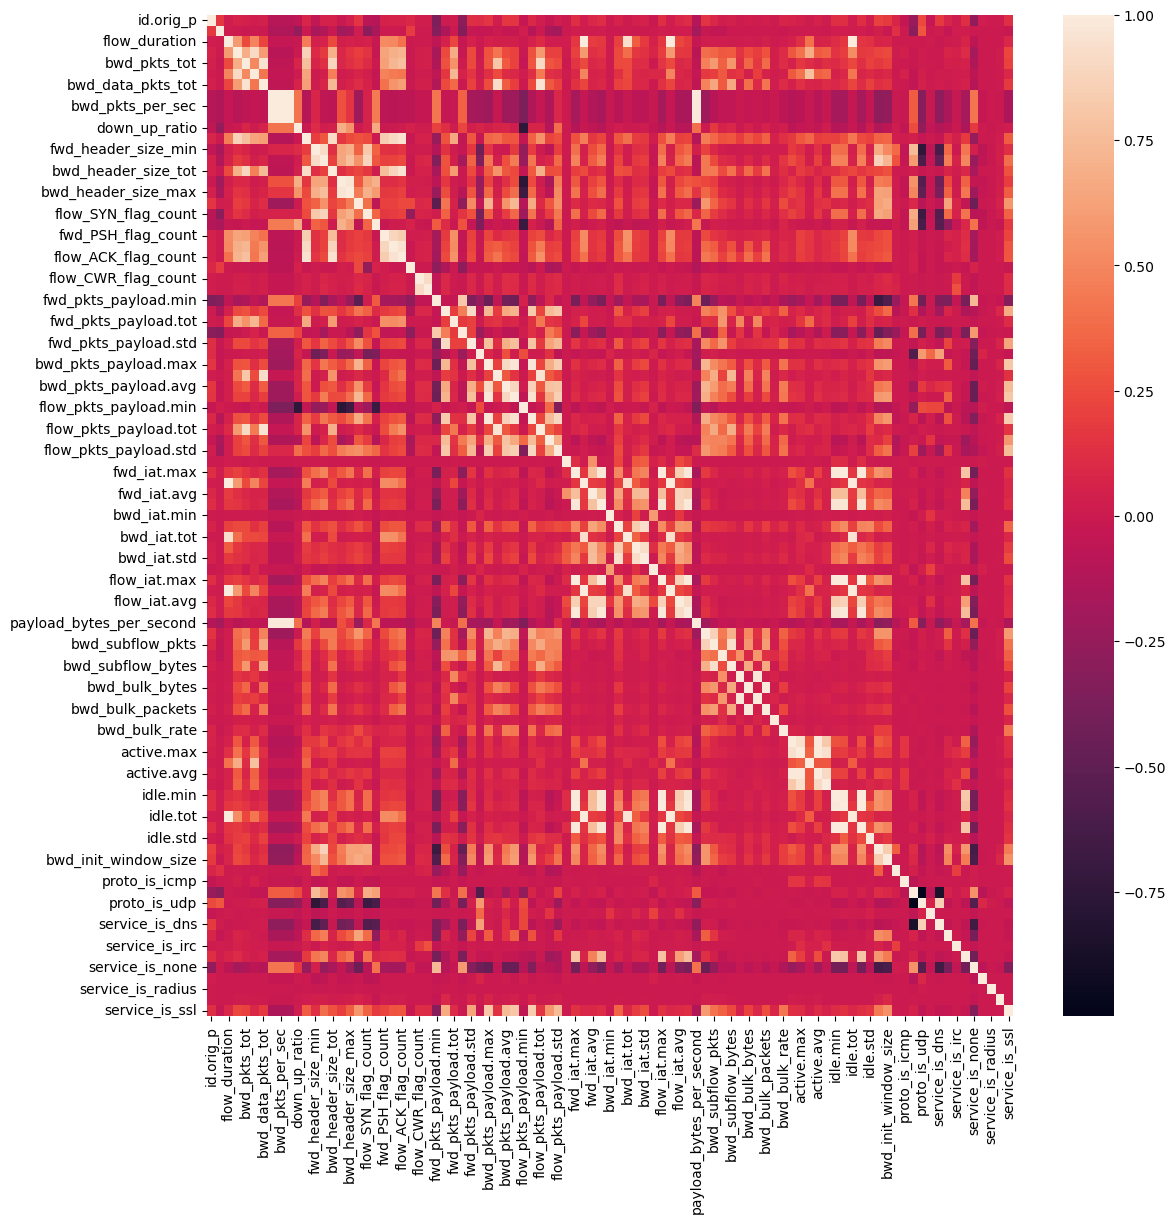

In [248]:
plt.figure(figsize=(13,13))
sns.heatmap(
    encoded_fixed[0].drop(["Attack_type"],axis=1).corr()
)
plt.show()

### Isolate features and target variable

At this point, I'm getting where I need to keep the features and target variable separate.

In [252]:
X_set = [df.drop("Attack_type",axis=1) for df in encoded_fixed]

In [254]:
[print(df.shape) for df in X_set]

(86181, 93)
(25855, 93)
(11081, 93)


[None, None, None]

In [256]:
y_set = [df["Attack_type"] for df in encoded_fixed]

In [258]:
[print(df.shape) for df in y_set]

(86181,)
(25855,)
(11081,)


[None, None, None]

### PCA

In [314]:
from sklearn.decomposition import PCA

In [322]:
pca = PCA(random_state=ranstate)

In [340]:
pd.DataFrame(pca.fit_transform(X_set[0],y_set[0]),columns=pca.get_feature_names_out())

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca83,pca84,pca85,pca86,pca87,pca88,pca89,pca90,pca91,pca92
0,-5.954315e+06,1.105558e+07,-2.479314e+06,4.626833e+06,255673.333964,71607.747637,-63221.836720,-137964.370670,23605.602297,32050.461402,...,0.000201,0.000217,-0.000019,0.000016,0.000021,0.000007,2.944637e-06,1.291634e-07,1.332980e-07,1.509337e-07
1,-5.965773e+06,9.217068e+06,-2.350419e+06,4.457896e+06,247691.669229,69405.170582,-61286.155713,-133738.972384,22881.626311,31065.848754,...,0.000749,0.000652,-0.000136,0.000044,-0.000009,0.000001,2.973378e-06,-1.870205e-08,1.068861e-06,-9.365199e-07
2,-5.770989e+06,4.047179e+07,-4.541622e+06,7.329784e+06,383377.540570,106834.280039,-94217.285711,-205529.025777,35148.206714,47709.766504,...,-0.003028,-0.002289,0.000289,0.000186,0.000083,-0.000002,1.780198e-08,2.662268e-10,-6.543326e-08,-1.208775e-07
3,-5.954315e+06,1.105558e+07,-2.479313e+06,4.626832e+06,255672.906441,71607.178725,-63222.376706,-137962.490215,23604.075533,32047.051575,...,0.000559,0.000502,-0.000095,0.000035,0.000002,0.000004,2.973616e-06,4.069938e-06,-1.071840e-07,4.717159e-08
4,-5.770989e+06,4.047179e+07,-4.541621e+06,7.329783e+06,383377.285633,106833.876931,-94217.662124,-205527.817976,35147.338801,47707.580356,...,-0.000967,0.002114,-0.002082,-0.000337,-0.000619,0.000051,-7.697361e-08,-1.210439e-07,-7.870528e-07,-5.594232e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86176,-5.919395e+06,1.665867e+07,-2.872133e+06,5.141681e+06,279996.202414,78317.760193,-69123.219926,-150832.972101,25805.064282,35035.767573,...,0.000156,0.000187,-0.000007,0.000014,0.000026,0.000007,3.100021e-06,-1.214531e-10,-5.844514e-10,-5.614477e-10
86177,-6.117273e+06,-1.509216e+07,-6.461545e+05,2.224210e+06,142164.314152,40295.001391,-35678.009044,-77910.810540,13343.684292,18124.968860,...,-0.000138,-0.000077,0.000042,-0.000004,0.000025,0.000005,2.360757e-06,-7.885077e-11,-7.385812e-10,-3.863007e-10
86178,-5.895649e+06,2.046877e+07,-3.139250e+06,5.491776e+06,296535.083665,82880.122865,-73136.172547,-159581.880797,27299.562471,37063.351333,...,0.000388,0.000375,-0.000055,0.000027,0.000016,0.000006,3.186895e-06,-8.444409e-11,-1.333687e-09,-9.597293e-11
86179,-6.010724e+06,2.004439e+06,-1.844759e+06,3.795156e+06,216382.067541,60768.714734,-53687.835259,-117176.838435,20053.327278,27229.828135,...,0.000104,0.000132,-0.000002,0.000010,0.000021,0.000006,-5.497736e-05,1.650689e-11,-3.199081e-10,-8.593361e-11


In [449]:
def pca_transform(X,y,ranstate=42):
    """
    Return 
    
    Parameters:
    -----------
    - X: DataFrame
        Data to be transformed
    - y: Series
        Target variable
    - ranstate: Int (Optional)
        Default = 42
    
    Returns:
    --------
    
    """
    
    # build the selector
    pca = PCA(random_state=ranstate)
    
    # export as dataframe
    df = pd.DataFrame(pca.fit_transform(X,y),columns=pca.get_feature_names_out())
    
    return df
    

In [451]:
pca_transform(X_set[0],y_set[0])

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca83,pca84,pca85,pca86,pca87,pca88,pca89,pca90,pca91,pca92
0,-5.954315e+06,1.105558e+07,-2.479314e+06,4.626833e+06,255673.333964,71607.747637,-63221.836720,-137964.370670,23605.602297,32050.461402,...,0.000201,0.000217,-0.000019,0.000016,0.000021,0.000007,2.944637e-06,1.291634e-07,1.332980e-07,1.509337e-07
1,-5.965773e+06,9.217068e+06,-2.350419e+06,4.457896e+06,247691.669229,69405.170582,-61286.155713,-133738.972384,22881.626311,31065.848754,...,0.000749,0.000652,-0.000136,0.000044,-0.000009,0.000001,2.973378e-06,-1.870205e-08,1.068861e-06,-9.365199e-07
2,-5.770989e+06,4.047179e+07,-4.541622e+06,7.329784e+06,383377.540570,106834.280039,-94217.285711,-205529.025777,35148.206714,47709.766504,...,-0.003028,-0.002289,0.000289,0.000186,0.000083,-0.000002,1.780198e-08,2.662268e-10,-6.543326e-08,-1.208775e-07
3,-5.954315e+06,1.105558e+07,-2.479313e+06,4.626832e+06,255672.906441,71607.178725,-63222.376706,-137962.490215,23604.075533,32047.051575,...,0.000559,0.000502,-0.000095,0.000035,0.000002,0.000004,2.973616e-06,4.069938e-06,-1.071840e-07,4.717159e-08
4,-5.770989e+06,4.047179e+07,-4.541621e+06,7.329783e+06,383377.285633,106833.876931,-94217.662124,-205527.817976,35147.338801,47707.580356,...,-0.000967,0.002114,-0.002082,-0.000337,-0.000619,0.000051,-7.697361e-08,-1.210439e-07,-7.870528e-07,-5.594232e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86176,-5.919395e+06,1.665867e+07,-2.872133e+06,5.141681e+06,279996.202414,78317.760193,-69123.219926,-150832.972101,25805.064282,35035.767573,...,0.000156,0.000187,-0.000007,0.000014,0.000026,0.000007,3.100021e-06,-1.214531e-10,-5.844514e-10,-5.614477e-10
86177,-6.117273e+06,-1.509216e+07,-6.461545e+05,2.224210e+06,142164.314152,40295.001391,-35678.009044,-77910.810540,13343.684292,18124.968860,...,-0.000138,-0.000077,0.000042,-0.000004,0.000025,0.000005,2.360757e-06,-7.885077e-11,-7.385812e-10,-3.863007e-10
86178,-5.895649e+06,2.046877e+07,-3.139250e+06,5.491776e+06,296535.083665,82880.122865,-73136.172547,-159581.880797,27299.562471,37063.351333,...,0.000388,0.000375,-0.000055,0.000027,0.000016,0.000006,3.186895e-06,-8.444409e-11,-1.333687e-09,-9.597293e-11
86179,-6.010724e+06,2.004439e+06,-1.844759e+06,3.795156e+06,216382.067541,60768.714734,-53687.835259,-117176.838435,20053.327278,27229.828135,...,0.000104,0.000132,-0.000002,0.000010,0.000021,0.000006,-5.497736e-05,1.650689e-11,-3.199081e-10,-8.593361e-11


### SelectKBest

In [261]:
from sklearn import feature_selection as fselect

In [263]:
kbest = fselect.SelectKBest(k=50)

In [265]:
kbest.fit(X_set[0],y_set[0])

SelectKBest(k=50)

In [267]:
kbest.get_feature_names_out()

array(['id.orig_p', 'id.resp_p', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec',
       'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_min',
       'fwd_header_size_max', 'bwd_header_size_min',
       'bwd_header_size_max', 'flow_FIN_flag_count',
       'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_URG_flag_count',
       'fwd_pkts_payload.min', 'fwd_pkts_payload.max',
       'fwd_pkts_payload.avg', 'fwd_pkts_payload.std',
       'bwd_pkts_payload.min', 'bwd_pkts_payload.max',
       'bwd_pkts_payload.avg', 'bwd_pkts_payload.std',
       'flow_pkts_payload.max', 'flow_pkts_payload.avg',
       'flow_pkts_payload.std', 'fwd_iat.max', 'fwd_iat.avg',
       'fwd_iat.std', 'flow_iat.max', 'flow_iat.avg', 'flow_iat.std',
       'payload_bytes_per_second', 'fwd_subflow_pkts', 'bwd_subflow_pkts',
       'active.min', 'idle.min', 'idle.max', 'idle.avg',
       'fwd_init_window_size', 'bwd_init_window_size',
       'fwd_last_window_size', 'proto_is_tcp', 'proto_is_udp',
       'service_is_

In [269]:
kbest.transform(X_set[0])

array([[7.81800000e+03, 2.10000000e+01, 2.46723765e+05, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.82400000e+04, 2.10000000e+01, 2.62144000e+05, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.53410000e+04, 2.10000000e+01, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [9.51800000e+03, 2.10000000e+01, 1.67772160e+05, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.10600000e+03, 2.10000000e+01, 3.22638769e+05, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.49990000e+04, 2.10000000e+01, 1.04857600e+06, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [271]:
# Get the most important features
pd.DataFrame(data=kbest.scores_,index=X_set[0].columns).sort_values(by=0,ascending=False)

,0
fwd_URG_flag_count,5.413222e+06
service_is_mqtt,2.433259e+06
service_is_none,1.436653e+05
fwd_pkts_payload.min,1.036721e+05
fwd_last_window_size,3.913950e+04
...,...
fwd_bulk_packets,2.202968e+01
fwd_bulk_rate,1.623044e+01
fwd_bulk_bytes,8.919058e+00
service_is_radius,8.469078e+00


In [275]:
# Return the transformed dataset
kbest_train = pd.DataFrame(data=kbest.transform(X_set[0]),columns=kbest.get_feature_names_out())

In [303]:
def kbest(X,y):
    """
    Returns a dataframe containing the top 50 KBest features.
    
    Parameters:
    -----------
    - X: DataFrame
        The data to be trained on
    - y: Series
        The target variable
    
    Returns:
    --------
    - kbest: DataFrame
        The transformed dataset
    
    """
    
    # Build the model
    kbest = fselect.SelectKBest(k=50)
    
    # fit and transform the model
    df_kbest = pd.DataFrame(data=kbest.fit_transform(X,y),columns=kbest.get_feature_names_out())
    
    return df_kbest

In [342]:
kbest(X_set[0],y_set[0])

,id.orig_p,id.resp_p,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_min,fwd_header_size_max,bwd_header_size_min,bwd_header_size_max,...,fwd_last_window_size,proto_is_tcp,proto_is_udp,service_is_dns,service_is_http,service_is_irc,service_is_mqtt,service_is_none,service_is_ssh,service_is_ssl
0,7818.0,21.0,2.467238e+05,2.467238e+05,4.934475e+05,1.0,20.0,20.0,20.0,20.0,...,64.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,28240.0,21.0,2.621440e+05,2.621440e+05,5.242880e+05,1.0,20.0,20.0,20.0,20.0,...,64.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,25341.0,21.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,20.0,20.0,0.0,0.0,...,64.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,20526.0,21.0,2.467238e+05,2.467238e+05,4.934475e+05,1.0,20.0,20.0,20.0,20.0,...,64.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,33928.0,137.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,8.0,8.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86176,3269.0,21.0,1.997288e+05,1.997288e+05,3.994575e+05,1.0,20.0,20.0,20.0,20.0,...,64.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
86177,9479.0,21.0,4.660338e+05,4.660338e+05,9.320676e+05,1.0,20.0,20.0,20.0,20.0,...,64.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
86178,9518.0,21.0,1.677722e+05,1.677722e+05,3.355443e+05,1.0,20.0,20.0,20.0,20.0,...,64.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
86179,9106.0,21.0,3.226388e+05,3.226388e+05,6.452775e+05,1.0,20.0,20.0,20.0,20.0,...,64.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [344]:
from sklearn.linear_model import LogisticRegression

In [388]:
lr = LogisticRegression(class_weight='balanced')

In [390]:
lr.fit(X_set[0],y_set[0])

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [392]:
lr.score(X_set[0],y_set[0])

0.7553289008018008

In [394]:
from sklearn.metrics import confusion_matrix

In [396]:
pd.DataFrame(confusion_matrix(y_set[0],lr.predict(X_set[0])))

,0,1,2,3,4,5,6,7,8,9,10,11
0,565,43,1282,180,1014,0,0,61,1665,0,153,462
1,18,191,144,1,16,0,0,0,3,0,0,1
2,0,0,58647,0,0,0,0,46,7568,0,0,0
3,1,1,0,2754,76,0,0,0,6,0,29,35
4,0,0,2,0,21,0,0,0,2,0,0,1
5,0,0,1,0,1,0,0,0,17,0,1,0
6,0,0,0,0,0,0,0,1400,0,0,0,0
7,0,0,2,0,3,0,0,696,0,0,0,0
8,1,0,97,0,10,0,0,1,1700,0,1,3
9,0,0,0,0,1,0,0,1397,8,0,1,0


In [398]:
lr.score(X_set[1][X_set[0].columns],y_set[1])

0.754476890350029

In [400]:
from sklearn.metrics import classification_report

In [402]:
print(classification_report(y_set[1],lr.predict(X_set[1][X_set[0].columns])))

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

            ARP_poisioning       0.94      0.10      0.18      1627
            DDOS_Slowloris       0.80      0.51      0.62       112
             DOS_SYN_Hping       0.97      0.89      0.93     19878
              MQTT_Publish       0.94      0.94      0.94       871
Metasploit_Brute_Force_SSH       0.01      0.88      0.01         8
             NMAP_FIN_SCAN       0.00      0.00      0.00         6
         NMAP_OS_DETECTION       0.00      0.00      0.00       420
             NMAP_TCP_scan       0.19      1.00      0.33       211
             NMAP_UDP_SCAN       0.15      0.93      0.26       544
       NMAP_XMAS_TREE_SCAN       0.00      0.00      0.00       422
               Thing_Speak       0.63      0.06      0.11      1703
                Wipro_bulb       0.03      0.51      0.06        53

                  accuracy                           0.75     25855
                 macro avg       0.39      0.4

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [404]:
print(classification_report(y_set[0],lr.predict(X_set[0][X_set[0].columns])))

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

            ARP_poisioning       0.90      0.10      0.19      5425
            DDOS_Slowloris       0.77      0.51      0.62       374
             DOS_SYN_Hping       0.97      0.89      0.93     66261
              MQTT_Publish       0.93      0.95      0.94      2902
Metasploit_Brute_Force_SSH       0.01      0.81      0.01        26
             NMAP_FIN_SCAN       0.00      0.00      0.00        20
         NMAP_OS_DETECTION       0.00      0.00      0.00      1400
             NMAP_TCP_scan       0.19      0.99      0.32       701
             NMAP_UDP_SCAN       0.15      0.94      0.26      1813
       NMAP_XMAS_TREE_SCAN       0.00      0.00      0.00      1407
               Thing_Speak       0.69      0.07      0.13      5675
                Wipro_bulb       0.04      0.64      0.07       177

                  accuracy                           0.76     86181
                 macro avg       0.39      0.4

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [407]:
from sklearn import metrics

In [417]:
metrics.roc_auc_score(y_set[1], lr.predict_proba(X_set[1][X_set[0].columns]), multi_class='ovr',average='weighted')

0.9821199429935952

In [415]:
metrics.roc_auc_score(y_set[1], lr.predict_proba(X_set[1][X_set[0].columns]), multi_class='ovo')

0.920794691001755

In [419]:
metrics.roc_auc_score(y_set[1], lr.predict_proba(X_set[1][X_set[0].columns]), multi_class='ovo',average='weighted')

0.9680510593589449

In [427]:
lr2 = LogisticRegression(max_iter=1000,class_weight='balanced')

In [429]:
lr2.fit(kbest_train,y_set[0])

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000)

In [433]:
metrics.roc_auc_score(y_set[0], lr2.predict_proba(kbest_train), multi_class='ovo',average='weighted')

0.9821552624929321

In [437]:
print(classification_report(y_set[0],lr2.predict(kbest_train)))

                            precision    recall  f1-score   support

            ARP_poisioning       0.66      0.48      0.55      5425
            DDOS_Slowloris       0.39      0.96      0.56       374
             DOS_SYN_Hping       1.00      0.88      0.94     66261
              MQTT_Publish       0.98      0.97      0.97      2902
Metasploit_Brute_Force_SSH       0.10      0.77      0.17        26
             NMAP_FIN_SCAN       0.00      0.85      0.00        20
         NMAP_OS_DETECTION       0.54      0.73      0.62      1400
             NMAP_TCP_scan       0.99      0.99      0.99       701
             NMAP_UDP_SCAN       0.61      0.69      0.65      1813
       NMAP_XMAS_TREE_SCAN       0.58      0.36      0.44      1407
               Thing_Speak       0.89      0.46      0.60      5675
                Wipro_bulb       0.34      0.67      0.45       177

                  accuracy                           0.82     86181
                 macro avg       0.59      0.7